In [411]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
from datetime import datetime as dt
import pickle

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

# Data Column Descriptions
C/A      = Control Area (A002)  
UNIT     = Remote Unit for a station (R051)  
SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)  
STATION  = Represents the station name the device is located at  
LINENAME = Represents all train lines that can be boarded at this station  
           Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.  
DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND     
DATE     = Represents the date (MM-DD-YY)  
TIME     = Represents the time (hh:mm:ss) for a scheduled audit event  
DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)  
           1. Audits may occur more that 4 hours due to planning, or troubleshooting activities.   
           2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered.   
ENTRIES  = The comulative entry register value for a device  
EXIST    = The cumulative exit register value for a device  

In [412]:
#define fun to get data from MTA urls
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

In [413]:
#use pickle to get summer info (jun, jul, aug) of 2016, 2017 and 2018
#total of 31 weeks
filename = 'bensonMTA.pkl'
try:
    with open(filename,'rb') as pklfile:
        df = pickle.load(pklfile)
except:
    week_nums = [160604, 160611, 160618, 160625, 160702, 160709, 160716, 160723, 
                 160730, 160806, 160813, 160820, 160827, 170603, 170610, 170617,
                 170624, 170701, 170708, 170715, 170722, 170729, 170805 ,170812,
                 170819, 170826, 180602, 180609, 180616, 180623, 180630]
    df = get_data(week_nums)
    with open(filename,'wb') as pklfile:
        df = pickle.dump(df, pklfile)

In [414]:
#first 5 rows of the data
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,00:00:00,REGULAR,5682962,1924340
1,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,04:00:00,REGULAR,5683000,1924347
2,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,08:00:00,REGULAR,5683030,1924381
3,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,12:00:00,REGULAR,5683175,1924474
4,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,16:00:00,REGULAR,5683437,1924533


In [415]:
#rows, columns
df.shape

(6063934, 11)

In [416]:
#colunm names
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [417]:
#take white space out from column names
df.columns = df.columns.str.strip()

In [418]:
#check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6063934 entries, 0 to 196689
Data columns (total 11 columns):
C/A         object
UNIT        object
SCP         object
STATION     object
LINENAME    object
DIVISION    object
DATE        object
TIME        object
DESC        object
ENTRIES     int64
EXITS       int64
dtypes: int64(2), object(9)
memory usage: 555.2+ MB


In [419]:
#basic data stats info 
df.describe()

,ENTRIES,EXITS
count,6.063934e+06,6.063934e+06
mean,3.819998e+07,3.054699e+07
std,2.042502e+08,1.837146e+08
min,0.000000e+00,0.000000e+00
25%,5.323435e+05,2.641282e+05
50%,2.620536e+06,1.494012e+06
75%,6.748129e+06,4.746630e+06
max,2.147483e+09,2.097116e+09


In [420]:
#create a date time column to combine DATE and TIME columns
df["DATE_TIME"] = pd.to_datetime(df.DATE + " " + df.TIME, format="%m/%d/%Y %H:%M:%S")

In [421]:
#check how many stations total
len(df.STATION.unique()) #380? Google says 424

380

In [422]:
#station names
df.STATION.unique()

array(['59 ST', '5 AV/59 ST', '57 ST-7 AV', '49 ST', 'TIMES SQ-42 ST',
       '34 ST-HERALD SQ', '28 ST', '23 ST', '14 ST-UNION SQ', '8 ST-NYU',
       'PRINCE ST', 'CANAL ST', 'CITY HALL', 'CORTLANDT ST', 'RECTOR ST',
       'WHITEHALL S-FRY', 'DELANCEY/ESSEX', 'BOWERY', 'CHAMBERS ST',
       'FULTON ST', 'BROAD ST', '7 AV', 'PARK PLACE', 'BOTANIC GARDEN',
       'PROSPECT PARK', 'PARKSIDE AV', 'CHURCH AV', 'BEVERLEY ROAD',
       'CORTELYOU RD', 'NEWKIRK PLAZA', 'AVENUE H', 'AVENUE J',
       'AVENUE M', 'KINGS HWY', 'AVENUE U', 'NECK RD', 'SHEEPSHEAD BAY',
       'BRIGHTON BEACH', 'OCEAN PKWY', 'BOROUGH HALL', 'JAY ST-METROTEC',
       'DEKALB AV', 'ATL AV-BARCLAY', 'UNION ST', '4AV-9 ST',
       'PROSPECT AV', '25 ST', '36 ST', '45 ST', '53 ST', 'BAY RIDGE AV',
       '77 ST', '86 ST', 'BAY RIDGE-95 ST', '8 AV', 'FT HAMILTON PKY',
       'NEW UTRECHT AV', '18 AV', '20 AV', 'BAY PKWY', '9 AV', '50 ST',
       '55 ST', '71 ST', '79 ST', '25 AV', 'BAY 50 ST', 'CONEY IS-STILLW',
      

In [423]:
#checking if there is more than one entry per station per particular time
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)
).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
2657354,N339A,R114,00-03-03,PARSONS BLVD,2016-08-09 04:00:00,2
2796334,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-08-09 16:00:00,2
2796326,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-08-08 08:00:00,2
2796327,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-08-08 12:00:00,2
2796328,N418,R269,01-05-00,BEDFORD-NOSTRAN,2016-08-08 16:00:00,2


In [424]:
#picked the first one and check why there is 2 entries
#looks like one is from a regular audit and one is from recover audit
#we need to get rid of one of them
#from the data decription we know that we should keep the recover audit
df[(df.DATE_TIME=="2016-08-09 04:00:00") & (df.STATION == "PARSONS BLVD") & (df.SCP == "00-03-03")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
86366,N339A,R114,00-03-03,PARSONS BLVD,F,IND,08/09/2016,04:00:00,REGULAR,839463,286664,2016-08-09 04:00:00
86367,N339A,R114,00-03-03,PARSONS BLVD,F,IND,08/09/2016,04:00:00,RECOVR AUD,806183,286664,2016-08-09 04:00:00


In [425]:
#this is the log before
#entries are 806173
#exits are 286643
df[(df.DATE_TIME=="2016-08-09 00:00:00") & (df.STATION == "PARSONS BLVD") & (df.SCP == "00-03-03")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
86365,N339A,R114,00-03-03,PARSONS BLVD,F,IND,08/09/2016,00:00:00,REGULAR,806173,286643,2016-08-09


In [426]:
#this is the log after
#entries are 806415
#exits are 286682
df[(df.DATE_TIME=="2016-08-09 08:00:00") & (df.STATION == "PARSONS BLVD") & (df.SCP == "00-03-03")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
86368,N339A,R114,00-03-03,PARSONS BLVD,F,IND,08/09/2016,08:00:00,REGULAR,806415,286682,2016-08-09 08:00:00


In [427]:
#checking how many regular and recover audit in total
df.DESC.value_counts()

REGULAR       6043854
RECOVR AUD      20080
Name: DESC, dtype: int64

In [428]:
#calculate what is the percentage of recover audit
#it is about 0.3 which is < 1%
#dropping these duplicate entries and it shouldn't cause too much problem
len(df[df.DESC == "RECOVR AUD"])/len(df)

0.003311381687201741

In [429]:
#we are dropping the duplicate that is regular, keep recover audit
df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], keep="last", inplace = True)

In [430]:
#check if we drop the right thing
#yes, we did
df[(df.DATE_TIME=="2016-08-09 04:00:00") & (df.STATION == "PARSONS BLVD") & (df.SCP == "00-03-03")]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
86367,N339A,R114,00-03-03,PARSONS BLVD,F,IND,08/09/2016,04:00:00,RECOVR AUD,806183,286664,2016-08-09 04:00:00


In [431]:
#there is no more duplicate entries
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)
).head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2016-05-28 00:00:00,1
4042568,R148,R033,01-03-00,TIMES SQ-42 ST,2016-08-22 04:00:00,1
4042577,R148,R033,01-03-00,TIMES SQ-42 ST,2016-08-23 16:00:00,1
4042576,R148,R033,01-03-00,TIMES SQ-42 ST,2016-08-23 12:00:00,1
4042575,R148,R033,01-03-00,TIMES SQ-42 ST,2016-08-23 08:00:00,1


In [432]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,00:00:00,REGULAR,5682962,1924340,2016-05-28 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,04:00:00,REGULAR,5683000,1924347,2016-05-28 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,08:00:00,REGULAR,5683030,1924381,2016-05-28 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,12:00:00,REGULAR,5683175,1924474,2016-05-28 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,16:00:00,REGULAR,5683437,1924533,2016-05-28 16:00:00


In [433]:
df.iloc[41:44]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
41,A002,R051,02-00-00,59 ST,NQR456,BMT,06/03/2016,20:00:00,REGULAR,5692327,1927289,2016-06-03 20:00:00
42,A002,R051,02-00-01,59 ST,NQR456,BMT,05/28/2016,00:00:00,REGULAR,5214625,1145501,2016-05-28 00:00:00
43,A002,R051,02-00-01,59 ST,NQR456,BMT,05/28/2016,04:00:00,REGULAR,5214654,1145507,2016-05-28 04:00:00


In [434]:
df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = df.groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES", "EXITS"].transform(lambda grp: grp.shift(1))

In [435]:
df.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [436]:
df["real_entries"] = df["ENTRIES"] - df["PREV_ENTRIES"]

In [437]:
df["real_exits"] = df["EXITS"] - df["PREV_EXITS"]

In [438]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,PREV_DATE,PREV_ENTRIES,PREV_EXITS,real_entries,real_exits
1,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,04:00:00,REGULAR,5683000,1924347,2016-05-28 04:00:00,05/28/2016,5682962.0,1924340.0,38.0,7.0
2,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,08:00:00,REGULAR,5683030,1924381,2016-05-28 08:00:00,05/28/2016,5683000.0,1924347.0,30.0,34.0
3,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,12:00:00,REGULAR,5683175,1924474,2016-05-28 12:00:00,05/28/2016,5683030.0,1924381.0,145.0,93.0
4,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,16:00:00,REGULAR,5683437,1924533,2016-05-28 16:00:00,05/28/2016,5683175.0,1924474.0,262.0,59.0
5,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,20:00:00,REGULAR,5683774,1924560,2016-05-28 20:00:00,05/28/2016,5683437.0,1924533.0,337.0,27.0


In [439]:
new_df = df.loc[df["real_entries"]>0]

In [443]:
len(new_df[new_df.real_entries<0])

0

In [444]:
len(new_df[new_df["real_exits"]<0])

17641

In [446]:
cleaned_df = new_df.loc[new_df["real_exits"]>0]

In [448]:
len(cleaned_df[cleaned_df["real_exits"]<0])

0

In [451]:
cleaned_df["total_traffic"] = cleaned_df["real_entries"] + cleaned_df["real_exits"]

/Users/ka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [454]:
cleaned_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,PREV_DATE,PREV_ENTRIES,PREV_EXITS,real_entries,real_exits,total_traffic
1,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,04:00:00,REGULAR,5683000,1924347,2016-05-28 04:00:00,05/28/2016,5682962.0,1924340.0,38.0,7.0,45.0
2,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,08:00:00,REGULAR,5683030,1924381,2016-05-28 08:00:00,05/28/2016,5683000.0,1924347.0,30.0,34.0,64.0
3,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,12:00:00,REGULAR,5683175,1924474,2016-05-28 12:00:00,05/28/2016,5683030.0,1924381.0,145.0,93.0,238.0
4,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,16:00:00,REGULAR,5683437,1924533,2016-05-28 16:00:00,05/28/2016,5683175.0,1924474.0,262.0,59.0,321.0
5,A002,R051,02-00-00,59 ST,NQR456,BMT,05/28/2016,20:00:00,REGULAR,5683774,1924560,2016-05-28 20:00:00,05/28/2016,5683437.0,1924533.0,337.0,27.0,364.0


In [461]:
cleaned_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])[ "total_traffic"].median().reset_index().nlargest(20, "total_traffic")

,C/A,UNIT,SCP,STATION,DATE_TIME,total_traffic
1537535,N100,R252,00-00-02,HIGH ST,2017-05-27 00:00:00,3.677284e+09
2706999,N600,R302,00-06-00,57 ST,2017-05-27 01:00:00,3.458216e+09
3630940,R204,R043,02-00-00,WALL ST,2017-08-05 10:00:00,3.399821e+09
1846246,N215,R237,00-00-02,182-183 STS,2018-06-24 16:00:00,3.320461e+09
640790,D008,R392,00-00-02,18 AV,2017-05-27 01:00:00,3.286467e+09
2451847,N506,R022,00-05-04,34 ST-HERALD SQ,2017-06-11 12:00:00,3.285201e+09
4950140,R730,R431,00-00-04,EASTCHSTER/DYRE,2017-05-27 01:00:00,3.284821e+09
1397581,N078,R175,01-03-00,14 ST,2017-05-27 01:00:00,3.267546e+09
1071838,N006A,R280,00-00-00,190 ST,2018-06-10 20:00:00,3.267539e+09
91440,A025,R023,01-03-01,34 ST-HERALD SQ,2017-05-27 00:00:00,3.034790e+09


TypeError: boxplot() got an unexpected keyword argument 'logy'

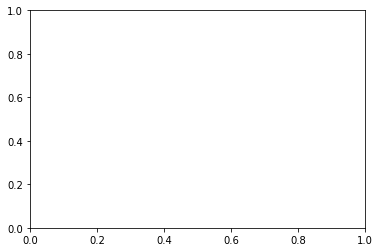

In [357]:
bp=df.boxplot(column=['Col1','Col2'], by=[])

In [301]:
#now the date_time is sorted and we can apply diff
df1 = df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])["ENTRIES", "EXITS"].first().reset_index()
df1.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,2016-05-28 00:00:00,5682962,1924340
1,A002,R051,02-00-00,59 ST,2016-05-28 04:00:00,5683000,1924347
2,A002,R051,02-00-00,59 ST,2016-05-28 08:00:00,5683030,1924381
3,A002,R051,02-00-00,59 ST,2016-05-28 12:00:00,5683175,1924474
4,A002,R051,02-00-00,59 ST,2016-05-28 16:00:00,5683437,1924533


In [ ]:
df1[df1.groupby(["C/A", "UNIT", "SCP", "STATION"]).ENTRIES.diff() <0]

In [197]:
df2 = df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", "DATE_TIME"])["ENTRIES", "EXITS"].first().reset_index()

In [277]:
df1.loc[11686:11690]

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS
11686,A002,R051,02-03-06,59 ST,2018-06-29 16:00:00,8554603,491068
11687,A002,R051,02-03-06,59 ST,2018-06-29 20:00:00,8555214,491073
11688,A002,R051,02-05-00,59 ST,2016-05-28 00:00:00,1284,0
11689,A002,R051,02-05-00,59 ST,2016-05-28 04:00:00,1284,0
11690,A002,R051,02-05-00,59 ST,2016-05-28 08:00:00,1284,0


ValueError: No axis named UNIT for object type <class 'pandas.core.frame.DataFrame'>

In [276]:
#lets find the daily entries
df1[df1.ENTRIES.diff()<0]

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS
1299,A002,R051,02-00-01,59 ST,2016-05-28 00:00:00,5214625,1145501
2598,A002,R051,02-03-00,59 ST,2016-05-28 00:00:00,706895,2670671
4434,A002,R051,02-03-01,59 ST,2017-05-27 00:00:00,299747,485275
6494,A002,R051,02-03-03,59 ST,2016-05-28 00:00:00,4563052,5484490
10390,A002,R051,02-03-06,59 ST,2016-05-28 00:00:00,7322834,473046
11688,A002,R051,02-05-00,59 ST,2016-05-28 00:00:00,1284,0
12986,A002,R051,02-05-01,59 ST,2016-05-28 00:00:00,0,699
15582,A006,R079,00-00-00,5 AV/59 ST,2016-05-28 02:00:00,2257571,3948984
18915,A006,R079,00-00-02,5 AV/59 ST,2017-06-18 14:00:00,5439480,16169264
19553,A006,R079,00-00-03,5 AV/59 ST,2016-05-28 02:00:00,2016180,754703


In [169]:
df["real_entries"] = df.ENTRIES.diff()

In [171]:
df[df.real_entries<0]

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME,real_entries
42,A002,R051,02-00-01,59 ST,NQR456,BMT,05/28/2016,00:00:00,REGULAR,5214625,1145501,2016-05-28 00:00:00,-4.777020e+05
84,A002,R051,02-03-00,59 ST,NQR456,BMT,05/28/2016,00:00:00,REGULAR,706895,2670671,2016-05-28 00:00:00,-4.515706e+06
168,A002,R051,02-03-02,59 ST,NQR456,BMT,05/28/2016,00:00:00,REGULAR,4915260,6804247,2016-05-28 00:00:00,-2.994420e+05
210,A002,R051,02-03-03,59 ST,NQR456,BMT,05/28/2016,00:00:00,REGULAR,4563052,5484490,2016-05-28 00:00:00,-3.609410e+05
336,A002,R051,02-03-06,59 ST,NQR456,BMT,05/28/2016,00:00:00,REGULAR,7322834,473046,2016-05-28 00:00:00,-2.025719e+06
378,A002,R051,02-05-00,59 ST,NQR456,BMT,05/28/2016,00:00:00,REGULAR,1284,0,2016-05-28 00:00:00,-7.334494e+06
420,A002,R051,02-05-01,59 ST,NQR456,BMT,05/28/2016,00:00:00,REGULAR,0,699,2016-05-28 00:00:00,-1.285000e+03
504,A006,R079,00-00-00,5 AV/59 ST,NQR,BMT,05/28/2016,02:00:00,REGULAR,2257571,3948984,2016-05-28 02:00:00,-4.202228e+06
630,A006,R079,00-00-03,5 AV/59 ST,NQR,BMT,05/28/2016,02:00:00,REGULAR,2016180,754703,2016-05-28 02:00:00,-5.353290e+06
756,A006,R079,00-03-01,5 AV/59 ST,NQR,BMT,05/28/2016,02:00:00,REGULAR,1797233,939964,2016-05-28 02:00:00,-6.111247e+06


In [81]:
#df2 = df.groupby(["C/A", "UNIT", "SCP", "STATION"]).count().reset_index().sort_values(by="STATION")

# Brent Code

In [9]:
df.columns = df.columns.str.strip()

In [10]:
df['real_entries'] = df['ENTRIES'].diff()
df['real_exits'] = df['EXITS'].diff()

In [11]:
df.loc[df['real_entries'] < 0] = np.nan
df.loc[df['real_exits'] < 0] = np.nan
df.loc[df['real_entries'] > 100000] = np.nan
df.loc[df['real_exits'] > 100000] = np.nan

In [12]:
print(df.columns)

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS', 'real_entries', 'real_exits'],
      dtype='object')


In [13]:
station_1_av = df[df['STATION'] == '1 AV']
print(df.sort_values(by='real_entries', ascending=False).head(100))

          C/A  UNIT       SCP          STATION  LINENAME DIVISION        DATE  \
111303  PTH03  R552  00-01-06   JOURNAL SQUARE         1      PTH  06/10/2017   
110547  N701A  R571  01-00-06      86 ST-2 AVE         Q      IND  08/12/2017   
135700   R162  R166  00-00-00            79 ST         1      IRT  06/10/2017   
113027  PTH03  R552  00-01-07   JOURNAL SQUARE         1      PTH  07/22/2017   
182738  R532H  R328  02-03-06  METS-WILLETS PT         7      IRT  06/23/2018   
115489  PTH09  R548  00-00-01   CHRISTOPHER ST         1      PTH  06/02/2018   
72348    N222  R156  00-00-03  BEDFORD PK BLVD        BD      IND  08/20/2016   
119033  PTH19  R549  02-01-00         NEWARK C         1      PTH  06/23/2018   
15748    B021  R228  00-03-02         AVENUE J        BQ      BMT  06/24/2017   
110277  PTH04  R551  00-00-01     GROVE STREET         1      PTH  07/09/2016   
111236  PTH03  R552  00-01-06   JOURNAL SQUARE         1      PTH  06/17/2017   
120262  PTH22  R540  02-01-0

In [14]:
print(df.groupby(['STATION'])['real_entries', 'real_exits'].mean())

                 real_entries  real_exits
STATION                                  
1 AV               318.415228  334.072472
103 ST             314.824013  206.380580
103 ST-CORONA      331.300445  238.459042
104 ST              73.686547   29.539430
110 ST             279.750978  221.128489
111 ST             153.091589   87.440391
116 ST             230.172450  120.539650
116 ST-COLUMBIA    302.300402  155.915208
121 ST              47.908292   27.221920
125 ST             263.052845  212.095206
135 ST             126.885632   52.184644
137 ST CITY COL    202.559081  162.018789
138/GRAND CONC     153.881248  136.606445
14 ST              201.006396  169.957293
14 ST-UNION SQ     394.999413  343.998947
145 ST             278.203925  225.935255
149/GRAND CONC     248.672782  173.610247
14TH STREET        133.024044  173.515094
15 ST-PROSPECT      79.576130   42.258820
155 ST             122.558099   77.983372
157 ST             193.884235  125.571778
161/YANKEE STAD    112.767321   99

In [15]:
new_df = df.groupby(['STATION'])['real_entries', 'real_exits'].mean()

In [16]:
totals = {}
for index, row in new_df.iterrows():
    totals[index] = row['real_entries'] + row['real_exits']

In [19]:
sorted_totals = sorted(totals.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_totals)

[('86 ST-2 AVE', 901.9401186836899), ('PATH WTC 2', 881.9185347184253), ('JFK JAMAICA CT1', 811.8362651228383), ('YORK ST', 809.802624671916), ('MYRTLE AV', 742.8002336448598), ('PATH NEW WTC', 741.4062947522516), ('14 ST-UNION SQ', 738.9983597594314), ('BEDFORD AV', 690.1554110488009), ('1 AV', 652.4877001171417), ('FLUSHING-MAIN', 630.7427495616682), ('GRD CNTRL-42 ST', 626.5143280266568), ('W 4 ST-WASH SQ', 623.3202697701197), ('34 ST-HERALD SQ', 608.9619719149698), ('191 ST', 588.5060334760608), ('NEWKIRK PLAZA', 585.9550808858176), ('JOURNAL SQUARE', 581.7479705573081), ('JKSN HT-ROOSVLT', 577.5329341317365), ('TIMES SQ-42 ST', 573.9001820628513), ('30 AV', 573.0040444893832), ('GRAND ST', 572.3809037988358), ('103 ST-CORONA', 569.759487045276), ('PAVONIA/NEWPORT', 566.6720863090716), ('NOSTRAND AV', 558.5766235788817), ('HOYT-SCHER', 556.9626314963102), ('8 AV', 555.2796259665528), ('ASTORIA DITMARS', 554.8303010958613), ('42 ST-BRYANT PK', 552.0162001853569), ('MONTROSE AV', 550

In [15]:
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/09/2017,03:00:00,REGULAR,6437543,2178597
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/09/2017,07:00:00,REGULAR,6437552,2178605
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/09/2017,11:00:00,REGULAR,6437616,2178685
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/09/2017,15:00:00,REGULAR,6437819,2178743
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/09/2017,19:00:00,REGULAR,6438141,2178804


In [16]:
df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198466 entries, 0 to 198465
Data columns (total 11 columns):
C/A                                                                     198466 non-null object
UNIT                                                                    198466 non-null object
SCP                                                                     198466 non-null object
STATION                                                                 198466 non-null object
LINENAME                                                                198466 non-null object
DIVISION                                                                198466 non-null object
DATE                                                                    198466 non-null object
TIME                                                                    198466 non-null object
DESC                                                                    198466 non-null object
ENTRIES                           

In [17]:
df.groupby("STATION").mean()

,ENTRIES,EXITS
STATION,,
1 AV,3.042608e+08,1.642164e+08
103 ST,9.831896e+06,4.109778e+07
103 ST-CORONA,6.921741e+06,7.229776e+06
104 ST,5.383409e+08,3.913867e+08
110 ST,5.482944e+06,5.378770e+06
111 ST,7.466841e+06,3.981487e+06
116 ST,7.771047e+07,9.391956e+07
116 ST-COLUMBIA,2.030876e+08,4.340227e+07
121 ST,3.176593e+07,1.270808e+06


# Sandbox

In [60]:
df1 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160604.txt")
df2 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160611.txt")
df3 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160618.txt")
df4 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160625.txt")

df5 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160702.txt")
df6 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160709.txt")
df7 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160716.txt")
df8 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160723.txt")
df9 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160730.txt")

df10 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160806.txt")
df11 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160813.txt")
df12 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160820.txt")
df13 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_160827.txt")

df14 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt")
df15 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170610.txt")
df16 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170617.txt")
df17 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170624.txt")

df18 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170701.txt")
df19 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170708.txt")
df20 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170715.txt")
df21 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170722.txt")
df22 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170729.txt")

df23 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170805.txt")
df24 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170812.txt")
df25 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170819.txt")
df26 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170826.txt")

df27 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_180602.txt")
df28 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_180609.txt")
df29 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180616.txt')
df30 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_180623.txt")
df31 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_180630.txt")

In [62]:
urls = ["http://web.mta.info/developers/data/nyct/turnstile/turnstile_160604.txt", 
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160611.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160618.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160625.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160702.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160709.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160716.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160723.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160730.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160806.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160813.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160820.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_160827.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170603.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170610.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170617.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170624.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170701.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170708.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170715.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170722.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170729.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170805.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170812.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170819.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_170826.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_180602.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_180609.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_180616.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_180623.txt",
            "http://web.mta.info/developers/data/nyct/turnstile/turnstile_180630.txt"]

dfs = [pd.read_csv(url) for url in urls]
df = pd.concat(dfs)